In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from utils import (
    detrend, monthly_anomalies,
    standardize, reg_slope, corr_with_ttest,
)

In [2]:
t_grid_file = xr.open_zarr('data/ORCA025.L46-KFS006_TroPA.zarr')

In [3]:
eq = dict(lat=0,lon=slice(140,260))

## Load input data 

### D20 

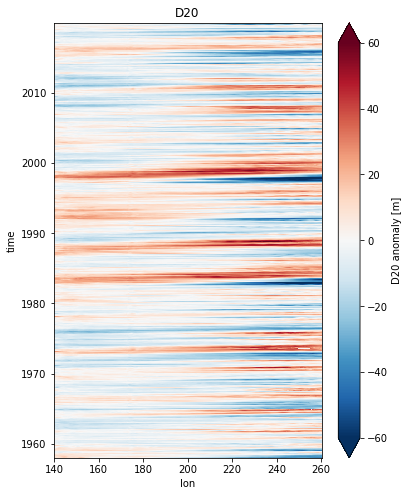

In [4]:
d20_mon_anom = monthly_anomalies(
    (-1) * t_grid_file.d20.sel(**eq)
)
d20_mon_anom.attrs.update({"long_name": "D20 anomaly", "units": "m", "positive": "up"})

d20_eq = detrend(
    d20_mon_anom.fillna(0.).compute()
).rename('D20')

plt.figure(figsize=(6, 8))
d20_eq.T.plot(vmin=-60,vmax=60,cmap=plt.cm.RdBu_r)
plt.title("D20");

### SST

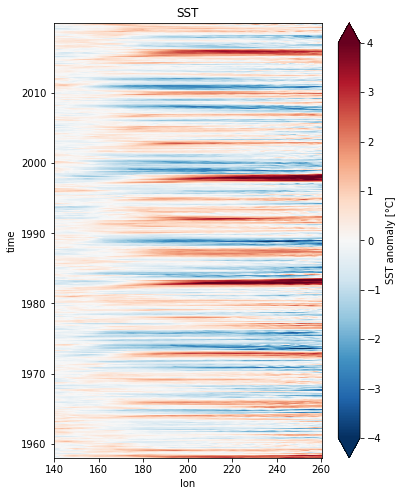

In [5]:
sst_o = t_grid_file.sosstsst.sel(**eq)

sst_mon_anom = monthly_anomalies(sst_o)
sst_mon_anom.attrs.update({"long_name": "SST anomaly", "units": "°C"})

sst_eq = detrend(sst_mon_anom.compute()).rename('SST')

plt.figure(figsize=(6, 8))
sst_eq.T.plot(vmin=-4,vmax=4,cmap=plt.cm.RdBu_r)
plt.title("SST");

### SSH 

In [6]:
ssh_o = t_grid_file.sossheig.sel(**eq)

ssh_mon_anom = monthly_anomalies(ssh_o)

ssh_mon_anom.attrs.update({"long_name": "SSH anomaly", "units": "m"})

ssh_eq = detrend(ssh_mon_anom.compute()).rename('SSH')

## Create time series
### NTI

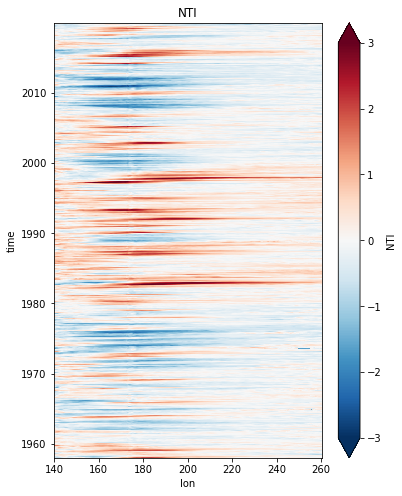

In [7]:
nti_eq = standardize(ssh_eq) + standardize(d20_eq)

nti_eq = nti_eq.rename('NTI')

plt.figure(figsize=(6, 8))
nti_eq.T.plot(vmin=-3,vmax=3,cmap=plt.cm.RdBu_r,extend="both")
plt.title("NTI");

### SST-k*D20 (linear remove effect of thermocline displacement on SST) 

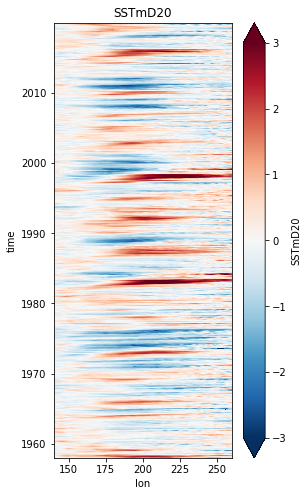

In [8]:
slope = reg_slope(d20_eq, sst_eq, dim="time")

sstmd20 = (
    sst_eq - slope * d20_eq
).rename("SSTmD20")

sstmd20=detrend(
    sstmd20
)

plt.figure(figsize=(4, 8))
sstmd20.T.plot(vmin=-3,vmax=3,cmap=plt.cm.RdBu_r)
plt.title("SSTmD20");

## Variance

In [9]:
ds = xr.Dataset(
    {"SST": sst_eq, "D20": d20_eq, "SSTmD20": sstmd20, "NTI": nti_eq, "SSH":ssh_eq})

ds = xr.Dataset(
    dict(
        SST=sst_eq,
        D20=d20_eq,
        SSTmD20=sstmd20,
        NTI=nti_eq,
        SSH=ssh_eq
    )
)
# use the unbiased estimator of the sample variance
variance = ds.var("time", ddof=1)
variance = variance.rename({k: f"var_{k}" for k in ("SST", "D20", "SSTmD20", "NTI", "SSH")})

## Correlations

In [10]:
sig_level = 0.95

rho_nti, rho_nti_lower, rho_nti_upper = corr_with_ttest(
    ds.SST, ds.NTI,
    dim="time",
    sig=sig_level
)
rho_SSTmD20, rho_SSTmD20_lower, rho_SSTmD20_upper = corr_with_ttest(
    ds.SST, ds.SSTmD20,
    dim="time",
    sig=sig_level
)
rho_D20, rho_D20_lower, rho_D20_upper = corr_with_ttest(
    ds.SST, ds.D20,
    dim="time",
    sig=sig_level
)

correlation = xr.Dataset(
    dict(
        corr_d20_sst=rho_D20,
        corr_nti_sst=rho_nti,
        corr_sstmd20_sst=rho_SSTmD20,
        corr_d20_sst_lower=rho_D20_lower,
        corr_d20_sst_upper=rho_D20_upper,
        corr_nti_sst_lower=rho_nti_lower,
        corr_nti_sst_upper=rho_nti_upper,
        corr_sstmd20_sst_lower=rho_SSTmD20_lower,
        corr_sstmd20_sst_upper=rho_SSTmD20_upper,
    )
)

## Write output

In [11]:
!rm -rf data_fig1.zarr
ds.merge(variance).merge(correlation).to_zarr("data_fig1.zarr");